# Training script for the WaveNet network on the VCTK corpus.

This script trains a network with the WaveNet using data from the VCTK corpus,
which can be freely downloaded at the following site (~10 GB):
http://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function

import argparse
from datetime import datetime
import json
import os
import sys
import time
import librosa
import librosa.display
import numpy as np
import numpy.random as random
from IPython.display import Audio
from IPython.display import Image
import IPython.display

import tensorflow as tf
from tensorflow.python.client import timeline

from wavenet import WaveNetModel, AudioReader, optimizer_factory, mu_law_decode, mu_law_encode

In [3]:
!nvidia-smi

Tue May 29 16:03:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   33C    P8    17W / 250W |   4164MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   29C    P8    16W / 250W |  10136MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
# gpu
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
BATCH_SIZE = 1
DATA_DIRECTORY = './VCTK-Corpus'
LOGDIR_ROOT = './logdir'
CHECKPOINT_EVERY = 50
NUM_STEPS = int(1e5)
LEARNING_RATE = 1e-3
WAVENET_PARAMS = './wavenet_params.json'
STARTED_DATESTRING = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
SAMPLE_SIZE = 100000
L2_REGULARIZATION_STRENGTH = 0
SILENCE_THRESHOLD = 0.05
EPSILON = 0.001
MOMENTUM = 0.9
MAX_TO_KEEP = 5
METADATA = False

In [19]:
def get_arguments(args):
    def _str_to_bool(s):
        """Convert string to bool (in argparse context)."""
        if s.lower() not in ['true', 'false']:
            raise ValueError('Argument needs to be a '
                             'boolean, got {}'.format(s))
        return {'true': True, 'false': False}[s.lower()]

    parser = argparse.ArgumentParser(description='WaveNet example network')
    parser.add_argument('--batch_size', type=int, default=BATCH_SIZE,
                        help='How many wav files to process at once. Default: ' + str(BATCH_SIZE) + '.')
    parser.add_argument('--data_dir', type=str, default=DATA_DIRECTORY,
                        help='The directory containing the VCTK corpus.')
    parser.add_argument('--store_metadata', type=bool, default=METADATA,
                        help='Whether to store advanced debugging information '
                        '(execution time, memory consumption) for use with '
                        'TensorBoard. Default: ' + str(METADATA) + '.')
    parser.add_argument('--logdir', type=str, default=None,
                        help='Directory in which to store the logging '
                        'information for TensorBoard. '
                        'If the model already exists, it will restore '
                        'the state and will continue training. '
                        'Cannot use with --logdir_root and --restore_from.')
    parser.add_argument('--logdir_root', type=str, default=None,
                        help='Root directory to place the logging '
                        'output and generated model. These are stored '
                        'under the dated subdirectory of --logdir_root. '
                        'Cannot use with --logdir.')
    parser.add_argument('--restore_from', type=str, default=None,
                        help='Directory in which to restore the model from. '
                        'This creates the new model under the dated directory '
                        'in --logdir_root. '
                        'Cannot use with --logdir.')
    parser.add_argument('--checkpoint_every', type=int,
                        default=CHECKPOINT_EVERY,
                        help='How many steps to save each checkpoint after. Default: ' + str(CHECKPOINT_EVERY) + '.')
    parser.add_argument('--num_steps', type=int, default=NUM_STEPS,
                        help='Number of training steps. Default: ' + str(NUM_STEPS) + '.')
    parser.add_argument('--learning_rate', type=float, default=LEARNING_RATE,
                        help='Learning rate for training. Default: ' + str(LEARNING_RATE) + '.')
    parser.add_argument('--wavenet_params', type=str, default=WAVENET_PARAMS,
                        help='JSON file with the network parameters. Default: ' + WAVENET_PARAMS + '.')
    parser.add_argument('--sample_size', type=int, default=SAMPLE_SIZE,
                        help='Concatenate and cut audio samples to this many '
                        'samples. Default: ' + str(SAMPLE_SIZE) + '.')
    parser.add_argument('--l2_regularization_strength', type=float,
                        default=L2_REGULARIZATION_STRENGTH,
                        help='Coefficient in the L2 regularization. '
                        'Default: False')
    parser.add_argument('--silence_threshold', type=float,
                        default=SILENCE_THRESHOLD,
                        help='Volume threshold below which to trim the start '
                        'and the end from the training set samples. Default: ' + str(SILENCE_THRESHOLD) + '.')
    parser.add_argument('--optimizer', type=str, default='adam',
                        choices=optimizer_factory.keys(),
                        help='Select the optimizer specified by this option. Default: adam.')
    parser.add_argument('--momentum', type=float,
                        default=MOMENTUM, help='Specify the momentum to be '
                        'used by sgd or rmsprop optimizer. Ignored by the '
                        'adam optimizer. Default: ' + str(MOMENTUM) + '.')
    parser.add_argument('--histograms', type=_str_to_bool, default=False,
                        help='Whether to store histogram summaries. Default: False')
    parser.add_argument('--gc_channels', type=int, default=None,
                        help='Number of global condition channels. Default: None. Expecting: Int')
    parser.add_argument('--max_checkpoints', type=int, default=MAX_TO_KEEP,
                        help='Maximum amount of checkpoints that will be kept alive. Default: '
                             + str(MAX_TO_KEEP) + '.')
    parser.add_argument('--lc_channels', type=int, default=0,
                        help='Number of local condition channels. Default: 0')
    parser.add_argument('--lc_maps_json', type=str, default=None,
                        help='The json file that specifies key value pair (wav filename, local condition csv filename),\
                              where all the paths inside are relative to data_dir. Default: None')    
    parser.add_argument('--dataset', type=str, default='VCTK-Corpus',
                        help='Datset configuration for audio reader. Currently support "VCTK-Corpus" and "CMU-Arctic-SLT".')    
    return parser.parse_args(args)


def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')


def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None


def get_default_logdir(logdir_root):
    logdir = os.path.join(logdir_root, 'train', STARTED_DATESTRING)
    return logdir


def validate_directories(args):
    """Validate and arrange directory related arguments."""

    if args.lc_channels > 0 and not args.lc_maps_json:        
        raise ValueError("--lc_channels and --lc_maps_json must be specified at the same time.")

    # Validation
    if args.logdir and args.logdir_root:
        raise ValueError("--logdir and --logdir_root cannot be "
                         "specified at the same time.")

    if args.logdir and args.restore_from:
        raise ValueError(
            "--logdir and --restore_from cannot be specified at the same "
            "time. This is to keep your previous model from unexpected "
            "overwrites.\n"
            "Use --logdir_root to specify the root of the directory which "
            "will be automatically created with current date and time, or use "
            "only --logdir to just continue the training from the last "
            "checkpoint.")

    # Arrangement
    logdir_root = args.logdir_root
    if logdir_root is None:
        logdir_root = LOGDIR_ROOT

    logdir = args.logdir
    if logdir is None:
        logdir = get_default_logdir(logdir_root)
        print('Using default logdir: {}'.format(logdir))

    restore_from = args.restore_from
    if restore_from is None:
        # args.logdir and args.restore_from are exclusive,
        # so it is guaranteed the logdir here is newly created.
        restore_from = logdir

    return {
        'logdir': logdir,
        'logdir_root': args.logdir_root,
        'restore_from': restore_from
    }


def test(net, sess, quantization_channels, lc_channels, lc, num_samples, seed=None, temperature=1, fast_generation=False):
    
    samples = tf.placeholder(tf.int32)
    if lc is not None:
        lc_placeholder = tf.placeholder(tf.float32)
    
    if fast_generation:
        next_sample = net.predict_proba_incremental(samples, None, local_condition = lc_placeholder)
    else:
        next_sample = net.predict_proba(samples, None,  local_condition = lc_placeholder)

    decode = mu_law_decode(samples, quantization_channels)
    
    # Silence with a single random sample at the end.
    # waveform = [np.random.randint(quantization_channels)]
    if seed is None:
        waveform = [quantization_channels/2]
    else:
        print("seed: "+str(seed))
        waveform = [seed]
    
    if lc is not None:
        waveform_lc = []
    
    probs = []

    last_sample_timestamp = datetime.now()
    for step in range(1, num_samples):
        if step % 1000 ==0:
            print(str(step)+"/"+str(num_samples))
        if lc_channels > 0:
            waveform_lc.append(list(lc[step, :]))
        if fast_generation:
            outputs = [next_sample]
            outputs.extend(net.push_ops)
            window = waveform[-1]
            if lc_channels > 0:
                lc_window = np.reshape(lc[step], (1, -1))
        else:
            if len(waveform) > net.receptive_field:
                window = waveform[-net.receptive_field:]
                if lc_channels > 0:
                    lc_window = np.reshape(waveform_lc[-net.receptive_field:], 
                                           (1, -1, lc_channels))
            else:
                window = waveform
                if lc_channels > 0:
                    lc_window = np.reshape(waveform_lc, (1, -1, lc_channels))
            outputs = [next_sample]
        
        # Run the WaveNet to predict the next sample.
        if  lc_channels > 0:
            prediction = sess.run(outputs, feed_dict={samples: window, lc_placeholder: lc_window})[0]
        else:
            prediction = sess.run(outputs, feed_dict={samples: window})[0]

        # Scale prediction distribution using temperature.
        np.seterr(divide='ignore')
        scaled_prediction = np.log(prediction) / temperature

        scaled_prediction = (scaled_prediction -
                             np.logaddexp.reduce(scaled_prediction))
        scaled_prediction = np.exp(scaled_prediction)
        np.seterr(divide='warn')

        # Prediction distribution at temperature=1.0 should be unchanged after
        # scaling.
        if temperature == 1.0:
            np.testing.assert_allclose(
                    prediction, scaled_prediction, atol=1e-5,
                    err_msg='Prediction scaling at temperature=1.0 '
                            'is not working as intended.')

        sample = np.random.choice(
            np.arange(quantization_channels), p=scaled_prediction)
        
        waveform.append(sample)
        probs.append(scaled_prediction)
        
    
    out = sess.run(decode, feed_dict={samples: waveform})
    return out, probs


def main(argv):
    args = get_arguments(argv)

    try:
        directories = validate_directories(args)
    except ValueError as e:
        print("Some arguments are wrong:")
        print(str(e))
        return

    logdir = directories['logdir']
    restore_from = directories['restore_from']

    # Even if we restored the model, we will treat it as new training
    # if the trained model is written into an arbitrary location.
    is_overwritten_training = logdir != restore_from

    with open(args.wavenet_params, 'r') as f:
        wavenet_params = json.load(f)

    # Create coordinator.
    coord = tf.train.Coordinator()

    # Load raw waveform from VCTK corpus.
    with tf.name_scope('create_inputs'):
        # Allow silence trimming to be skipped by specifying a threshold near
        # zero.
        silence_threshold = args.silence_threshold if args.silence_threshold > \
                                                      EPSILON else None
        gc_enabled = args.gc_channels is not None
        reader = AudioReader(
            args.data_dir,
            coord,
            sample_rate=wavenet_params['sample_rate'],
            gc_enabled=gc_enabled,
            receptive_field=WaveNetModel.calculate_receptive_field(wavenet_params["filter_width"],
                                                                   wavenet_params["dilations"],
                                                                   wavenet_params["scalar_input"],
                                                                   wavenet_params["initial_filter_width"]),
            sample_size=args.sample_size,
            silence_threshold = silence_threshold,
            lc_maps_json = args.lc_maps_json,
            dataset = args.dataset)
        audio_batch = reader.dequeue(args.batch_size)

        if gc_enabled:
            gc_id_batch = reader.dequeue_gc(args.batch_size)
        else:
            gc_id_batch = None

        if args.lc_channels > 0:
            lc_batch = reader.dequeue_lc(args.batch_size)
        else:
            lc_batch = None
        
        """For test set"""
        test_batch = reader.dequeue_test(1)
        if args.lc_channels > 0:
            test_lc_batch = reader.dequeue_test_lc(1)

    # Create network.
    net = WaveNetModel(
        batch_size=args.batch_size,
        dilations=wavenet_params["dilations"],
        filter_width=wavenet_params["filter_width"],
        residual_channels=wavenet_params["residual_channels"],
        dilation_channels=wavenet_params["dilation_channels"],
        skip_channels=wavenet_params["skip_channels"],
        quantization_channels=wavenet_params["quantization_channels"],
        use_biases=wavenet_params["use_biases"],
        scalar_input=wavenet_params["scalar_input"],
        initial_filter_width=wavenet_params["initial_filter_width"],
        histograms=args.histograms,
        global_condition_channels=args.gc_channels,
        global_condition_cardinality=reader.gc_category_cardinality,
        local_condition_channels=args.lc_channels)

    if args.l2_regularization_strength == 0:
        args.l2_regularization_strength = None
    loss, prediction, target_output = net.loss(input_batch=audio_batch,
                                               global_condition_batch=gc_id_batch,
                                               l2_regularization_strength=args.l2_regularization_strength,
                                               local_condition_batch=lc_batch)
    optimizer = optimizer_factory[args.optimizer](
                    learning_rate=args.learning_rate,
                    momentum=args.momentum)
    trainable = tf.trainable_variables()
    optim = optimizer.minimize(loss, var_list=trainable)

    ##### For record only #####
    # Output to prediction, for wav output
    proba = tf.cast(tf.nn.softmax(tf.cast(prediction, tf.float64)), tf.float32)

    # Set up logging for TensorBoard.
    writer = tf.summary.FileWriter(logdir)
    writer.add_graph(tf.get_default_graph())
    run_metadata = tf.RunMetadata()
    summaries = tf.summary.merge_all()

    # Set up session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    init = tf.global_variables_initializer()
    sess.run(init)

    # Saver for storing checkpoints of the model.
    saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=args.max_checkpoints)

    try:
        saved_global_step = load(saver, sess, restore_from)
        if is_overwritten_training or saved_global_step is None:
            # The first training step will be saved_global_step + 1,
            # therefore we put -1 here for new or overwritten trainings.
            saved_global_step = -1

    except:
        print("Something went wrong while restoring checkpoint. "
              "We will terminate training to avoid accidentally overwriting "
              "the previous model.")
        raise

    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    reader.start_threads(sess, 1)
    
    step = None
    last_saved_step = saved_global_step
    losses = []
    test_losses = []
    try:
        for step in range(saved_global_step + 1, args.num_steps):
            start_time = time.time()
            if args.store_metadata and step % 50 == 0:
                # Slow run that stores extra information for debugging.
                print('Storing metadata')
                run_options = tf.RunOptions(
                    trace_level=tf.RunOptions.FULL_TRACE)
                summary, loss_value, prob_value, target_output, _= sess.run(
                    [summaries, loss, prob, target_output, optim],
                    options=run_options,
                    run_metadata=run_metadata)
                writer.add_summary(summary, step)
                writer.add_run_metadata(run_metadata,
                                        'step_{:04d}'.format(step))
                tl = timeline.Timeline(run_metadata.step_stats)
                timeline_path = os.path.join(logdir, 'timeline.trace')
                with open(timeline_path, 'w') as f:
                    f.write(tl.generate_chrome_trace_format(show_memory=True))
            else:
                summary, loss_value, proba_value, target_output_value, _ = sess.run([summaries, 
                                                                                     loss, 
                                                                                     proba, 
                                                                                     target_output, 
                                                                                     optim])
                writer.add_summary(summary, step)
            
            
            duration = time.time() - start_time
            if step % 10 == 0:
                print('step {:d} - loss = {:.3f}, ({:.3f} sec/step)'
                      .format(step, loss_value, duration))
            losses.append(loss_value)                

            ##### For record only #####
            if step % 200 == 0:
                samples = np.array([random.choice(np.arange(wavenet_params["quantization_channels"]), p=proba_value[i])
                                    for i in range(proba_value.shape[0])])
                decode = mu_law_decode(samples, wavenet_params['quantization_channels'])
                target_samples = np.array([random.choice(np.arange(wavenet_params["quantization_channels"]), p=target_output_value[i])
                                            for i in range(target_output_value.shape[0])])
                decode_target_output = mu_law_decode(target_samples, wavenet_params["quantization_channels"])
                
                if step % 1000 == 0:
                    test_ground = sess.run(test_batch)[0]
                    test_lc = sess.run(test_lc_batch)[0]
                
                    net.batch_size = 1
                    
                    encoded_target = mu_law_encode(test_ground, wavenet_params["quantization_channels"])
                    test_waveform, test_probs = test(net, sess, wavenet_params["quantization_channels"], 
                                                     args.lc_channels, test_lc, test_ground.shape[0],
                                                     seed=sess.run(encoded_target[0]))
                    encoded_t = sess.run(net._one_hot(encoded_target))
                    net.batch_size = args.batch_size
                
                    test_probs_np = np.asarray(test_probs)
                    
                    test_loss = sess.run(tf.reduce_mean(
                                                        tf.nn.softmax_cross_entropy_with_logits(
                                                            logits=test_probs_np, 
                                                            labels=encoded_t[0, 1:]
                                                        )
                                                    )
                                        )
                    test_losses.append((step, test_loss))
                
                IPython.display.clear_output(wait=False)
                
                print("====== Training result ======")
                IPython.display.display(Audio(sess.run(decode), rate=wavenet_params['sample_rate']))
                IPython.display.display(Audio(sess.run(decode_target_output), rate=wavenet_params['sample_rate']))
                
                if len(test_losses)>0:
                    wave_length = len(test_waveform)
                    
                    print("====== Test result ======")
                    print(test_ground.shape, test_lc.shape, len(test_waveform), np.array(test_probs).shape)
                    plt.figure(figsize=(16,20))
                    
                    plt.subplot(511)
                    plt.ylim((-1, 1))
                    plt.xlim((0, test_ground.shape[0]))
                    plot(np.arange(test_ground.shape[0]), test_ground[:, 0])
                    
                    plt.subplot(512)
                    plt.ylim((-1, 1))
                    plt.xlim((0, len(test_waveform)))
                    plot(np.arange(len(test_waveform)), test_waveform)
                    
                    plt.subplot(513)
                    plt.imshow(np.array(encoded_t[0, 1:]).T, aspect="auto", origin="lower")
                    
                    plt.subplot(514)
                    plt.imshow(np.array(test_probs).T, aspect="auto", origin="lower")
                    
                    plt.subplot(515)
                    # librosa.display.specshow(test_lc.T, sr=wavenet_params['sample_rate'], hop_length=80)
                    plt.imshow(test_lc.T, aspect="auto", origin="lower")
                    # colorbar()
                    show()

                    IPython.display.display(Audio(test_ground[:, 0], rate=wavenet_params['sample_rate']))
                    IPython.display.display(Audio(test_waveform, rate=wavenet_params['sample_rate']))
                
                plt.figure(figsize=(16,4))
                plt.ylim((0, 6))
                plt.xlim((step+1-len(losses), step+1))
                plot(np.arange(step+1-len(losses), step+1), losses, 'b')
                if len(test_losses)>0:
                    plot(list(zip(*test_losses)[0]), list(zip(*test_losses)[1]), 'r')
                show()
                print(test_losses)

            if step % args.checkpoint_every == 0:
                save(saver, sess, logdir, step)
                last_saved_step = step

    except KeyboardInterrupt:
        # Introduce a line break after ^C is displayed so save message
        # is on its own line.
        print()
    finally:
        if step > last_saved_step:
            save(saver, sess, logdir, step)
        coord.request_stop()
        coord.join(threads)

## Args for p225, mfcc local conditions (48k) and small architecture

In [7]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/p225_mfcc_fix"])
# argv.extend(['--data_dir', "../VCTK-Corpus/wav48/p225"])
# argv.extend(['--lc_channels', "20"])
# argv.extend(['--lc_maps_json', "../VCTK-Corpus/wav48/p225/maps_p225.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "6"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# print(argv)
# main(argv)

## Args for p225, mgc local conditions (16k) and small architecture

In [8]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/p225_mgc_fix"])
# argv.extend(['--data_dir', "../VCTK-Corpus/wav48/p225"])
# argv.extend(['--lc_channels', "26"])
# argv.extend(['--lc_maps_json', "../VCTK-Corpus/wav48/p225/mgc_p225.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "6"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# print(argv)
# main(argv)

## Args for p225, mcc local conditions (16k) and mid architecture

In [9]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/p225_mcc"])
# argv.extend(['--data_dir', "../VCTK-Corpus/wav48/p225"])
# argv.extend(['--lc_channels', "26"])
# argv.extend(['--lc_maps_json', "../VCTK-Corpus/wav48/p225/mcc_p225.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "24"])
# argv.extend(['--wavenet_params', "./wavenet_params3.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# print(argv)
# main(argv)

## Args for p225, mfcc local conditions (16k) and small architecture, CMU Dataset

In [10]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/cmu_mfcc40"])
# argv.extend(['--data_dir', "../cmu_us_slt_arctic"])
# argv.extend(['--lc_channels', "40"])
# argv.extend(['--lc_maps_json', "../cmu_us_slt_arctic/mfcc40.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "6"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# argv.extend(['--dataset', 'CMU-Arctic-SLT'])
# print(argv)
# main(argv)

## Args for p225, mfcc local conditions (40 coeff, 48k) and small architecture, CMU Dataset

In [11]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/cmu_mfcc40_48k"])
# argv.extend(['--data_dir', "../cmu_us_slt_arctic"])
# argv.extend(['--lc_channels', "40"])
# argv.extend(['--lc_maps_json', "../cmu_us_slt_arctic/mfcc40_48k.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "6"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# argv.extend(['--dataset', 'CMU-Arctic-SLT'])
# print(argv)
# main(argv)

## Args for mfcc local conditions (25+1 coeff, 16k， hop_length = 80, frame_length = 1024) and small architecture, CMU Dataset

In [12]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/mfcc25+1_16k"])
# argv.extend(['--data_dir', "../cmu_us_slt_arctic"])
# argv.extend(['--lc_channels', "26"])
# argv.extend(['--lc_maps_json', "../cmu_us_slt_arctic/mfcc25+1_16k.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "8"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "8000"])
# argv.extend(['--num_steps', "100000"])
# argv.extend(['--dataset', 'CMU-Arctic-SLT'])
# print(argv)
# main(argv)

## "VALID"->"SAME" Args for mfcc local conditions (20 coeff, 48k->16k， hop_length = 80, frame_length = 1024) and small architecture, CMU Dataset

====== Training result ======


====== Test result ======
(15000, 1) (15000, 20) 15000 (15000, 256)


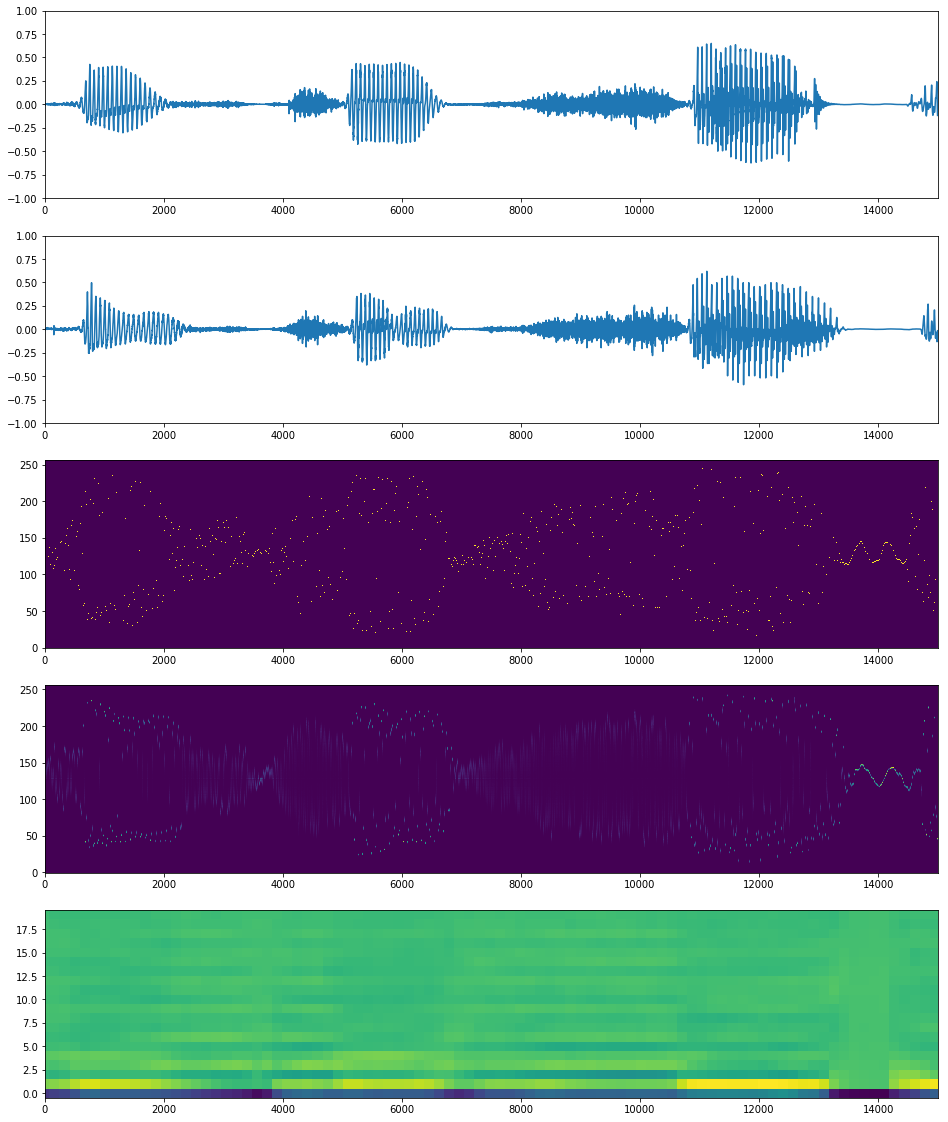

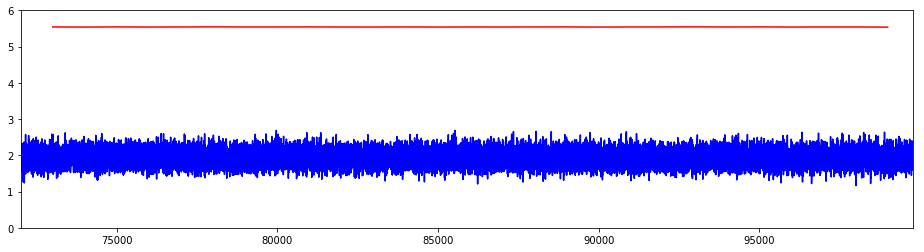

[(73000, 5.5422506), (74000, 5.5391197), (75000, 5.543455), (76000, 5.539997), (77000, 5.5419207), (78000, 5.544754), (79000, 5.541783), (80000, 5.541726), (81000, 5.543178), (82000, 5.5409136), (83000, 5.5405583), (84000, 5.542174), (85000, 5.540079), (86000, 5.541582), (87000, 5.5407085), (88000, 5.542651), (89000, 5.5431895), (90000, 5.538277), (91000, 5.5424147), (92000, 5.5427856), (93000, 5.544575), (94000, 5.5413094), (95000, 5.5436897), (96000, 5.5399647), (97000, 5.541965), (98000, 5.5419335), (99000, 5.537521)]
Storing checkpoint to ./logdir/train/CMU_alt_no_noise_retrain_mfcc20_48k ... Done.
step 99810 - loss = 1.763, (0.694 sec/step)
step 99820 - loss = 1.756, (0.704 sec/step)
step 99830 - loss = 2.205, (0.696 sec/step)
step 99840 - loss = 1.818, (0.710 sec/step)
step 99850 - loss = 2.071, (0.724 sec/step)
Storing checkpoint to ./logdir/train/CMU_alt_no_noise_retrain_mfcc20_48k ... Done.
step 99860 - loss = 2.113, (0.694 sec/step)
step 99870 - loss = 2.042, (0.832 sec/step)

In [13]:
# tf.reset_default_graph()
# argv =[]
# argv.extend(['--logdir', "./logdir/train/CMU_alt_no_noise_retrain_mfcc20_48k"])
# argv.extend(['--data_dir', "../cmu_us_slt_arctic"])
# argv.extend(['--lc_channels', "20"])
# argv.extend(['--lc_maps_json', "../cmu_us_slt_arctic/mfcc20_48k.json"])
# argv.extend(['--learning_rate', "0.001"])
# argv.extend(['--batch_size', "6"])
# argv.extend(['--wavenet_params', "./wavenet_params2.json"])
# argv.extend(['--sample_size', "6000"])
# argv.extend(['--num_steps', "100000"])
# argv.extend(['--dataset', 'CMU-Arctic-SLT'])
# print(argv)
# main(argv)

## "VALID"->"SAME" Args for mgc local conditions (26 coeff (order 25), 16k，hop_length = 128, frame_length = 512) and small architecture, CMU Dataset

====== Training result ======


====== Test result ======
(15000, 1) (15000, 26) 15000 (14999, 256)


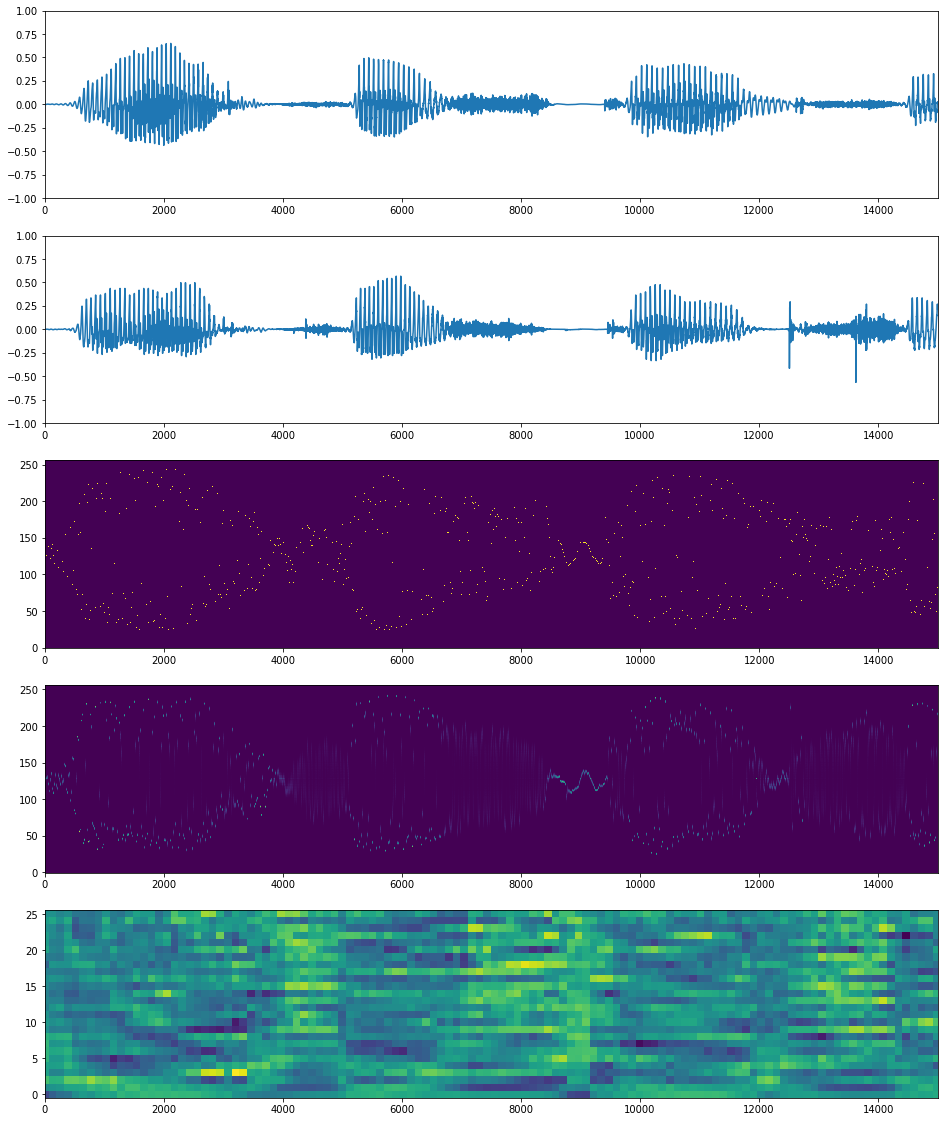

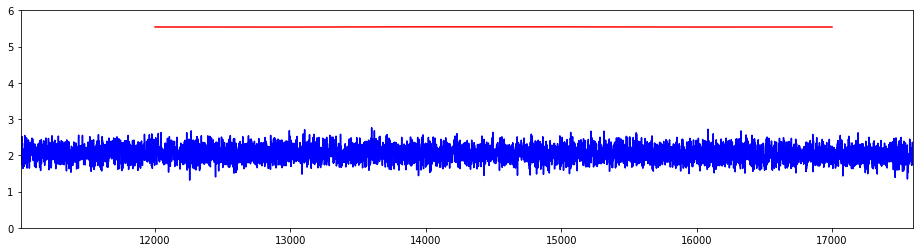

[(12000, 5.541442), (13000, 5.539272), (14000, 5.5460052), (15000, 5.5444965), (16000, 5.539946), (17000, 5.540862)]
Storing checkpoint to ./logdir/train/CMU_alt_no_noise_mgc_26 ... Done.
step 17610 - loss = 1.862, (0.848 sec/step)
step 17620 - loss = 1.838, (0.841 sec/step)
step 17630 - loss = 1.856, (0.831 sec/step)


In [ ]:
tf.reset_default_graph()
argv =[]
argv.extend(['--logdir', "./logdir/train/CMU_alt_no_noise_mgc_26"])
argv.extend(['--data_dir', "../cmu_us_slt_arctic"])
argv.extend(['--lc_channels', "26"])
argv.extend(['--lc_maps_json', "../cmu_us_slt_arctic/mgc_26.json"])
argv.extend(['--learning_rate', "0.001"])
argv.extend(['--batch_size', "6"])
argv.extend(['--wavenet_params', "./wavenet_params2.json"])
argv.extend(['--sample_size', "6000"])
argv.extend(['--num_steps', "100000"])
argv.extend(['--dataset', 'CMU-Arctic-SLT'])
print(argv)
main(argv)